# SHAP

SHAP (SHapley Additive exPlanations) is a method used to explain the output of machine learning models.  
SHAP aims to explain how an input affects the output of the model, by showing the impact of each input feature on the output.  
When reading the SHAP values, you will see for each input feature how much it positively or negatively pushed the output to the answer we got, compared to the average base value of the dataset.

You can read more here: https://trustyai-explainability.github.io/trustyai-site/main/local-explainers.html

In [1]:
!pip -q install "numpy==1.26.4" "tensorflow==2.18.0"


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import warnings

# Ignore UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import pickle
import pandas as pd
import numpy as np
import keras

2024-12-20 08:12:56.958394: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 08:12:56.971798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734682376.986522    8913 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734682376.991089    8913 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 08:12:57.006290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
OUTPUT_FEATURE = "price"

Let's start by loading some artifacts.  
We will need:
- The ONNX model
- Our pre-and-post processing artifacts
    - scaler.pkl
    - label_encoder.pkl
- Some data
    - The training inputs, these will be used to get an average input for our dataset
    - The test data, these will be used to get a point we want to analyze

In [5]:
keras_model = keras.saving.load_model("artifacts/model.keras")

with open('artifacts/feature_scaler.pkl', 'rb') as handle:
    feature_scaler = pickle.load(handle)
with open('artifacts/label_scaler.pkl', 'rb') as handle:
    label_scaler = pickle.load(handle)

test_data = pd.read_parquet('artifacts/X_test.parquet')
train_data = pd.read_parquet('artifacts/X_train.parquet')

2024-12-20 08:12:58.754408: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
train_data["price"].dtype == "float64"

True

In [7]:
strange_prediction = test_data.loc[[532]].drop(OUTPUT_FEATURE, axis=1)
strange_prediction

,sellable_online,other_colors,depth,height,width,discounted,width_d,height_d,depth_d,discount_amount,...,category_Children's furniture,category_Nursery furniture,category_Outdoor furniture,category_Room dividers,"category_Sideboards, buffets & console tables",category_Sofas & armchairs,category_TV & media furniture,category_Tables & desks,category_Trolleys,category_Wardrobes
532,1,0,0.144531,0.012876,0.25194,1,0,1,1,0.009765,...,0,0,0,0,0,0,0,0,0,0


TrustyAI SHAP explainer requires our model to have a pandas dataframe as an input, and numpy or pandas output, so we wrap our model in a pred() function that makes sure the input and output are converted properly. 

In [8]:
def pred(x):
    prediction = keras_model.predict(x)
    return pd.DataFrame(prediction, columns=[OUTPUT_FEATURE])

In [9]:
from trustyai.model import Model
trustyai_model = Model(pred, output_names=[OUTPUT_FEATURE])

In [10]:
prediction = trustyai_model(strange_prediction)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


,price
0,-0.057931


In [11]:
for key in train_data.columns:
    test_data[[key]] = test_data[[key]].astype("float32")
    train_data[[key]] = train_data[[key]].astype("float32")
    try:
        strange_prediction[[key]] = strange_prediction[[key]].astype("float32")
    except:
        pass

We arbitrarily choose the first data point (song) in our test data to be the data we want to test.  
In practice, you might choose the data point that you predict the worst on, or a data point that gave an unexpected answer.  
We also look at how our data point looks when normalized (after going through pre-processing). This is how it will look like going into the model

Let's try to use our TrustyAI Model to predict the output of our data point we want to explain with SHAP.

And with everything set up, we can create a SHAP explainer and let it analyze our data point!  
You can also note that we add 100 data points from our training dataset to the SHAPExplainer, this is used to calculate the average base values of our dataset. With this, we can see how much our interesting datapoint contributes to the prediction compared to what a "standard" value would.

In [12]:
from trustyai.explainers import SHAPExplainer
explainer = SHAPExplainer(background=train_data[:100].drop(OUTPUT_FEATURE, axis=1))

In [13]:
explanations = explainer.explain(inputs=strange_prediction,
                                 outputs=prediction,
                                 model=trustyai_model)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/stepe
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step
63/63

With our SHAP Explainer ready we can start looking at the results.

Let's choose a specific output country which we want to know how it got affected by the input values.  
CH is the country that we are supposed to get as the popular country for this input, so it's especially interesting to see the input's effect on that output.  
That being said, feel free to try with a few other countries and see what happens.  

First, we will get a table of values.  
Here we can see the **Mean Background Value** - this is the average base value we were talking about before.  
We can also see our **Value**, which is the normalized data point that we sent into the explainer. Red values are lower than the average value and green values are higher.  
Finally, we have the **SHAP Value**. These indicate how much that input feature had an effect on the output. Red indicates a negative contribution to the prediction while green a positive contribution. The larger the value, the larger the contribution.

In [14]:
explanations.as_html()[OUTPUT_FEATURE]

,Feature,Value,Mean Background Value,SHAP Value,Confidence
0,Background,nan,nan,0.108714,nan
1,sellable_online,1.000000,1.000000,0.000000,0.000000
2,other_colors,0.000000,0.380000,-0.005711,0.001067
3,depth,0.144531,0.219692,-0.007021,0.001063
4,height,0.012876,0.143379,-0.024612,0.001075
5,width,0.251940,0.255130,0.002279,0.001107
6,discounted,1.000000,0.190000,-0.037789,0.001095
7,width_d,0.000000,0.790000,-0.028589,0.001071
8,height_d,1.000000,0.710000,0.000000,0.000000
9,depth_d,1.000000,0.550000,-0.002024,0.001070


We can also visualize it as a candlestick plot, seeing how the different input features build up to the output value.

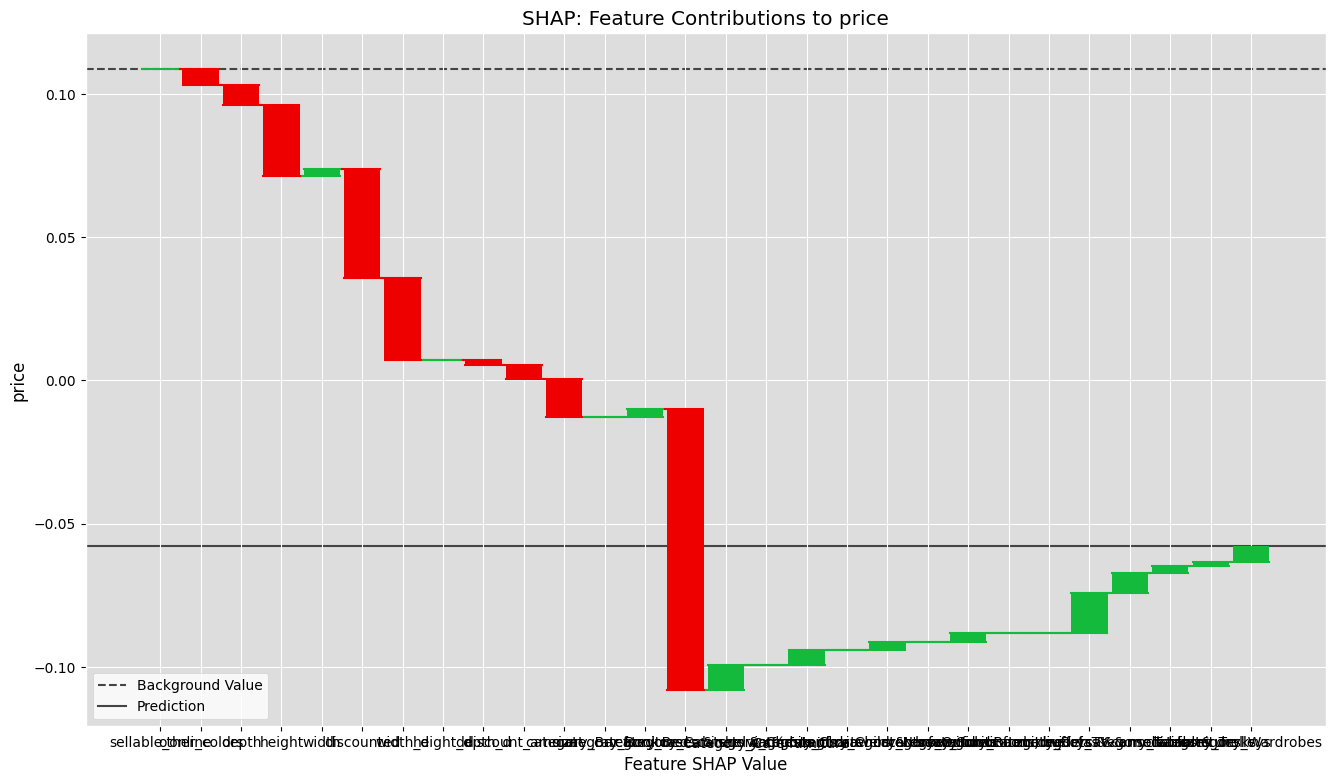

In [15]:
from trustyai.visualizations.shap import SHAPViz
SHAPViz()._matplotlib_plot(explanations=explanations, output_name=OUTPUT_FEATURE)